In [5]:
import pandas as pd
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import numpy as np
from fairlearn.datasets import fetch_acs_income
import shap

from scipy.spatial.distance import cosine, euclidean
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report,  roc_auc_score

import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from xgboost import XGBRegressor, XGBClassifier #continuous values?


In [6]:
raw_data = pd.read_csv(r"C:\Users\odiee\OneDrive\Documents\24-25\Blok4\HCML\Project\Notebooks\ACSPUMS1.csv")

In [7]:
print(raw_data.head())
raw_data.isna().sum()

   PWGTP  RAC1P  SEX  MAR  HICOV  DIS NAICSP  NATIVITY  ENG  SCHL  AGEP  \
0     13      1    1    1      2    2     23         1    0    17    35   
1     17      2    1    5      2    2      N         1    0    12    43   
2      6      2    2    5      1    1   4853         1    0    18    58   
3     12      1    1    5      2    2      N         1    0    12    25   
4     14      1    1    5      1    2  611M1         1    0    16    21   

   PINCP  WKHP  Unnamed: 13  
0  63000    80          NaN  
1      0     0          NaN  
2  23100    20          NaN  
3      0     0          NaN  
4  17000    40          NaN  


PWGTP                 0
RAC1P                 0
SEX                   0
MAR                   0
HICOV                 0
DIS                   0
NAICSP                0
NATIVITY              0
ENG                   0
SCHL                  0
AGEP                  0
PINCP                 0
WKHP                  0
Unnamed: 13    15912393
dtype: int64

In [8]:
# filter out NaN column
raw_data = raw_data.drop(columns=['Unnamed: 13'], errors='ignore')

# preprocess NAICS
raw_data = raw_data[raw_data['NAICSP'] !='N']
raw_data = raw_data[raw_data['NAICSP'] !=999920]

In [9]:
print(raw_data.head())

   PWGTP  RAC1P  SEX  MAR  HICOV  DIS NAICSP  NATIVITY  ENG  SCHL  AGEP  \
0     13      1    1    1      2    2     23         1    0    17    35   
2      6      2    2    5      1    1   4853         1    0    18    58   
4     14      1    1    5      1    2  611M1         1    0    16    21   
5     24      1    1    2      2    2    562         1    0    12    45   
6      5      6    2    5      1    2  611M1         2    0    19    21   

   PINCP  WKHP  
0  63000    80  
2  23100    20  
4  17000    40  
5   7700    50  
6   2000    15  


### Pre-processing: subsampling data

In [10]:
raw_data['strata'] = raw_data[['DIS', 'NATIVITY','RAC1P','SEX']].astype(str).agg('_'.join, axis=1)

sample,_ = train_test_split(raw_data, 
                             train_size=500_000, 
                             stratify=raw_data['strata'], 
                             random_state=42)




In [11]:
len(sample)

500000

### Check for proportions

In [12]:
print(raw_data['DIS'].value_counts(normalize=True))
print(sample['DIS'].value_counts(normalize=True)) 

print(raw_data['NATIVITY'].value_counts(normalize=True))
print(sample['NATIVITY'].value_counts(normalize=True))

print(raw_data['SEX'].value_counts(normalize=True))
print(sample['SEX'].value_counts(normalize=True))

DIS
2    0.902688
1    0.097312
Name: proportion, dtype: float64
DIS
2    0.90269
1    0.09731
Name: proportion, dtype: float64
NATIVITY
1    0.85568
2    0.14432
Name: proportion, dtype: float64
NATIVITY
1    0.855684
2    0.144316
Name: proportion, dtype: float64
SEX
1    0.513447
2    0.486553
Name: proportion, dtype: float64
SEX
1    0.513446
2    0.486554
Name: proportion, dtype: float64


In [13]:
print(raw_data['RAC1P'].value_counts(normalize=True))
print(sample['RAC1P'].value_counts(normalize=True))


RAC1P
1    0.700567
2    0.086076
9    0.085107
6    0.063519
8    0.052143
3    0.008784
7    0.001699
5    0.001549
4    0.000556
Name: proportion, dtype: float64
RAC1P
1    0.700564
2    0.086076
9    0.085108
6    0.063520
8    0.052140
3    0.008786
7    0.001700
5    0.001548
4    0.000558
Name: proportion, dtype: float64


In [14]:
print(raw_data['HICOV'].value_counts(normalize=True))
print(sample['HICOV'].value_counts(normalize=True))

HICOV
1    0.910656
2    0.089344
Name: proportion, dtype: float64
HICOV
1    0.910806
2    0.089194
Name: proportion, dtype: float64


In [15]:
sample.drop('strata', axis=1, inplace=True)
print(sample.head())

          PWGTP  RAC1P  SEX  MAR  HICOV  DIS NAICSP  NATIVITY  ENG  SCHL  \
11453635     17      1    1    3      1    2  8111Z         1    0    16   
4350620      14      8    1    1      2    2    488         2    2    16   
429287       13      9    1    3      1    2    53M         1    0    19   
5735460       6      1    1    1      1    1    488         1    0    12   
13535107     12      9    2    5      1    2  45942         1    0    18   

          AGEP  PINCP  WKHP  
11453635    46  49000    40  
4350620     46  -5600    32  
429287      61  72000    40  
5735460     56      0     0  
13535107    64  35200    20  


In [16]:
numeric_cols = ['AGEP', 'WKHP']
categorical_cols = ['DIS', 'NATIVITY','NAICSP','SCHL', 'MAR', 'ENG', 'SEX',  'RAC1P'] 


In [ ]:
insurance_data = sample.copy() # create new df for insurance predictions
income_data = sample.copy()

,PWGTP,RAC1P,SEX,MAR,target,DIS,NAICSP,NATIVITY,ENG,SCHL,AGEP,PINCP,WKHP
11453635,17,1,1,3,1,2,8111Z,1,0,16,46,49000,40
4350620,14,8,1,1,2,2,488,2,2,16,46,-5600,32
429287,13,9,1,3,1,2,53M,1,0,19,61,72000,40
5735460,6,1,1,1,1,1,488,1,0,12,56,0,0
13535107,12,9,2,5,1,2,45942,1,0,18,64,35200,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787000,15,6,1,1,1,2,531M,2,1,21,43,100000,40
178609,22,1,2,1,1,2,4591M,1,0,21,66,17000,30
11933843,28,1,1,1,1,2,623M,1,0,16,67,49800,8
13232362,9,1,2,5,1,2,522M,1,0,21,30,52000,42


In [31]:
insurance_data.rename(columns={"HICOV": "target"}, inplace=True)

In [23]:
income_data.drop(columns=["HICOV"])
income_data.rename(columns={"PINCP": "target"}, inplace=True)

In [24]:
print(income_data.columns)

Index(['PWGTP', 'RAC1P', 'SEX', 'MAR', 'HICOV', 'DIS', 'NAICSP', 'NATIVITY',
       'ENG', 'SCHL', 'AGEP', 'target', 'WKHP'],
      dtype='object')


## Data analysis/visualization

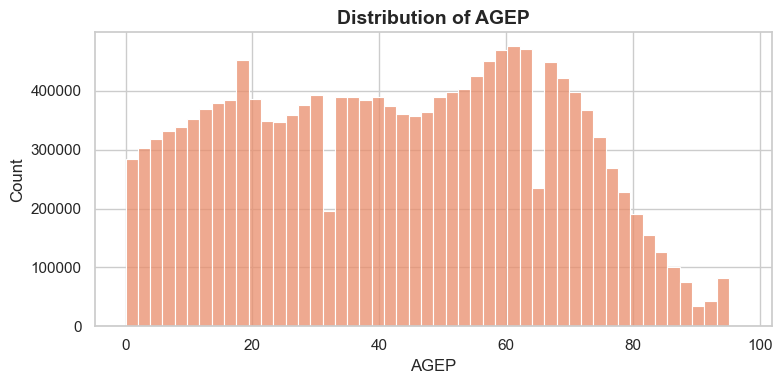

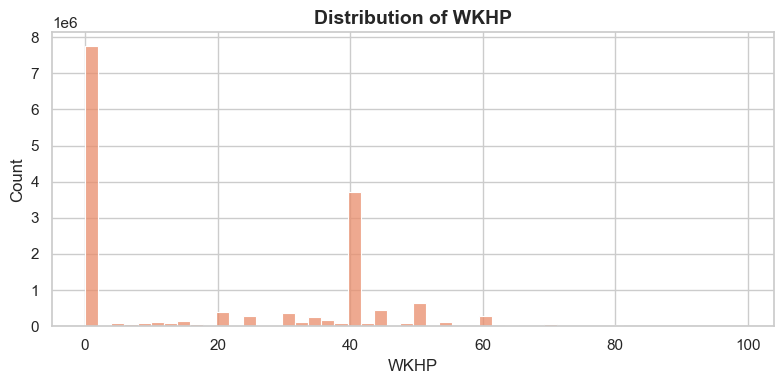

In [ ]:

sns.set_theme(style="whitegrid", palette="flare")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(insurance_data[col], bins=50, kde=False, color=sns.color_palette("flare")[0])
    plt.title(f'Distribution of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


### Categorical value visualization

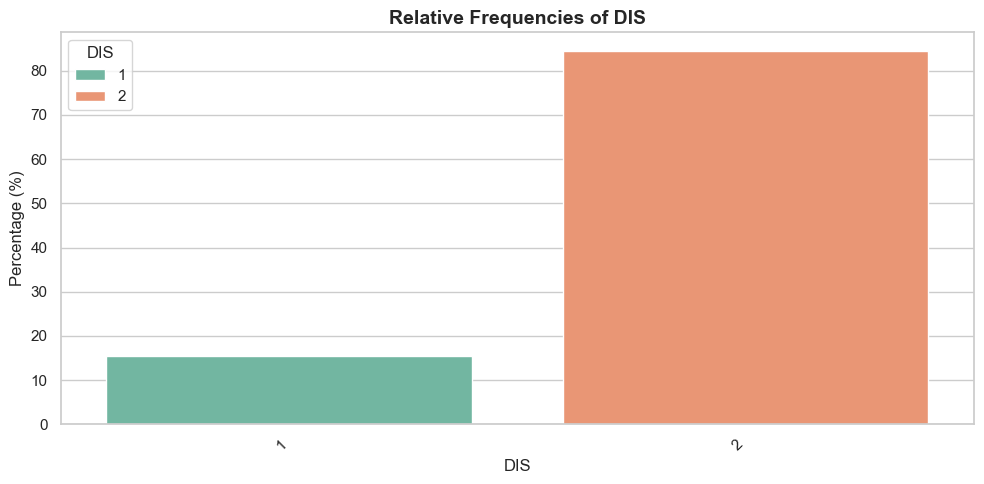

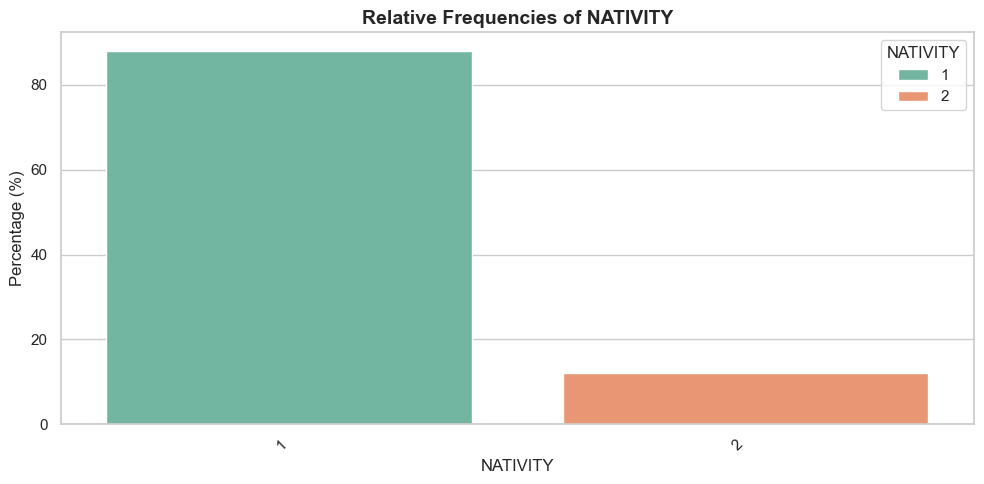

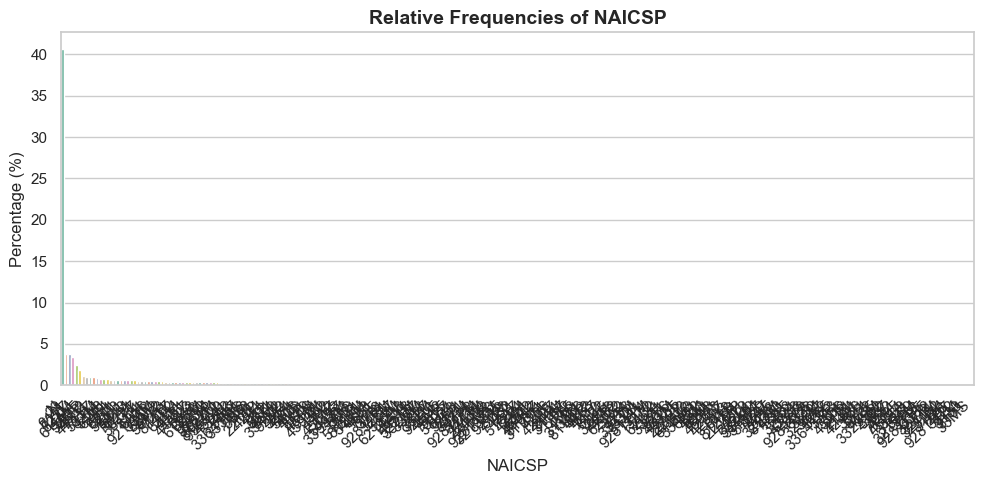

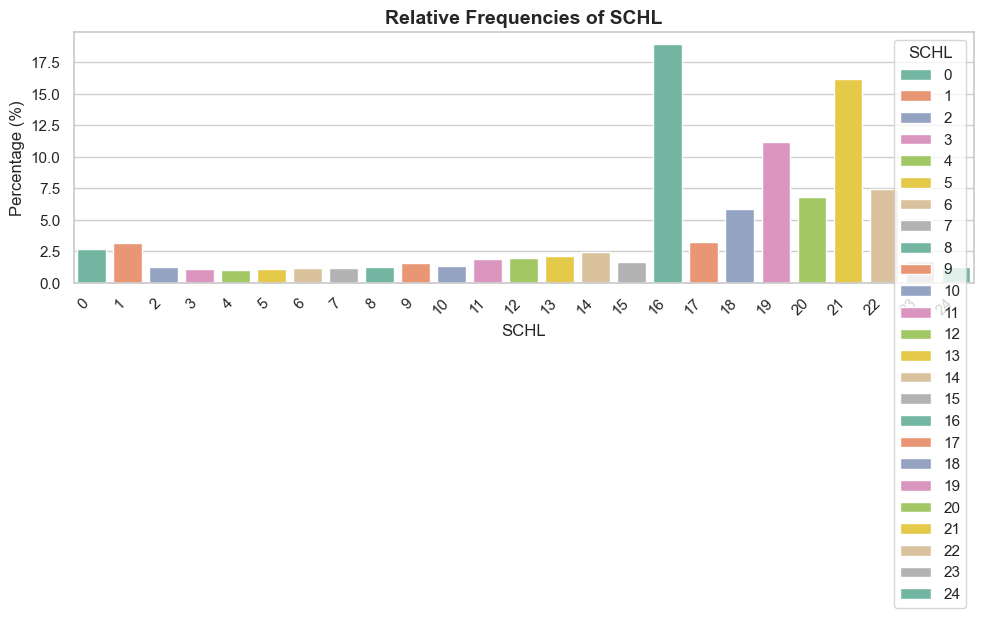

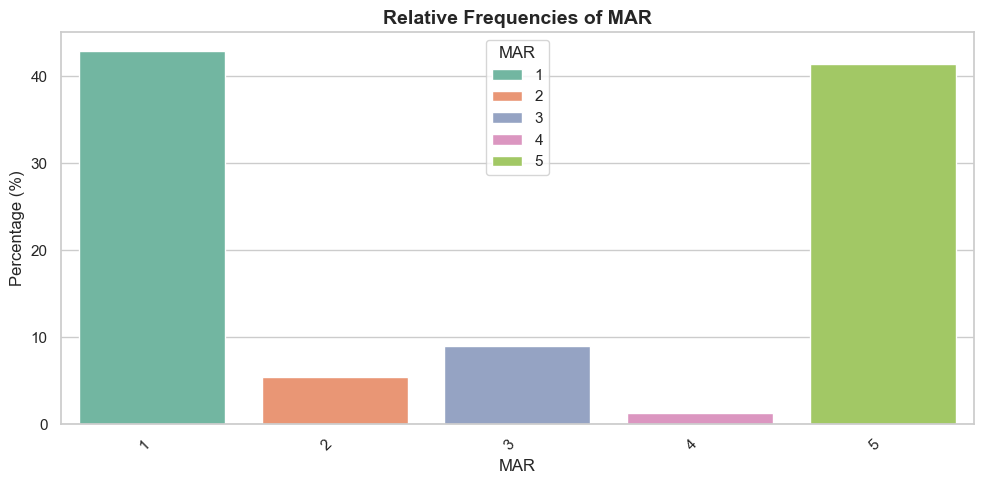

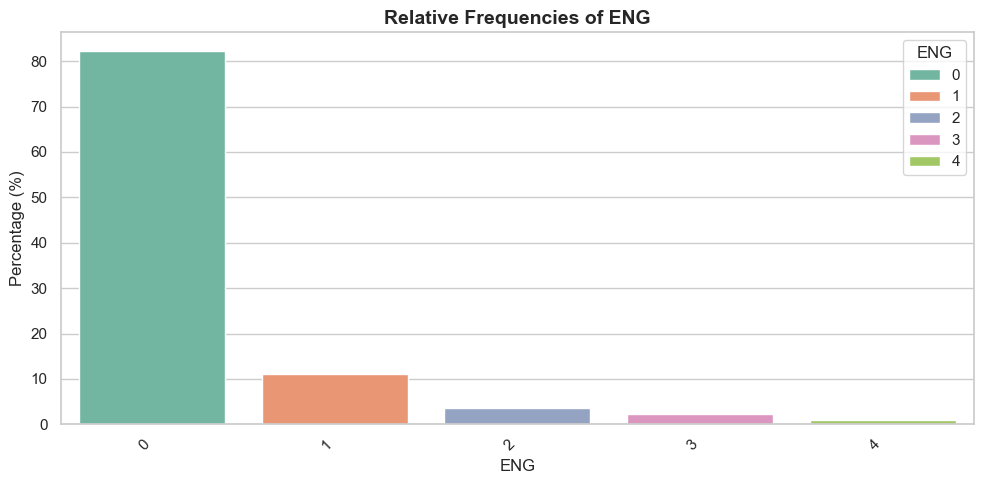

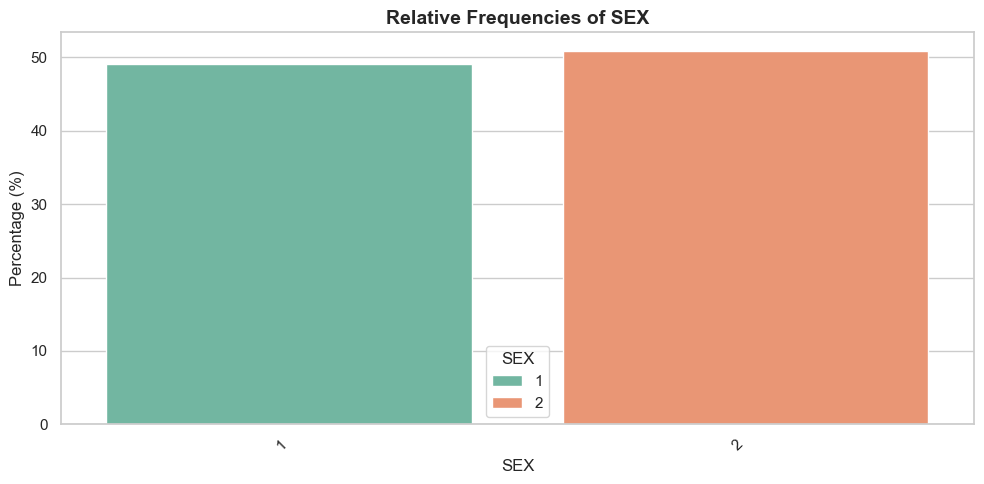

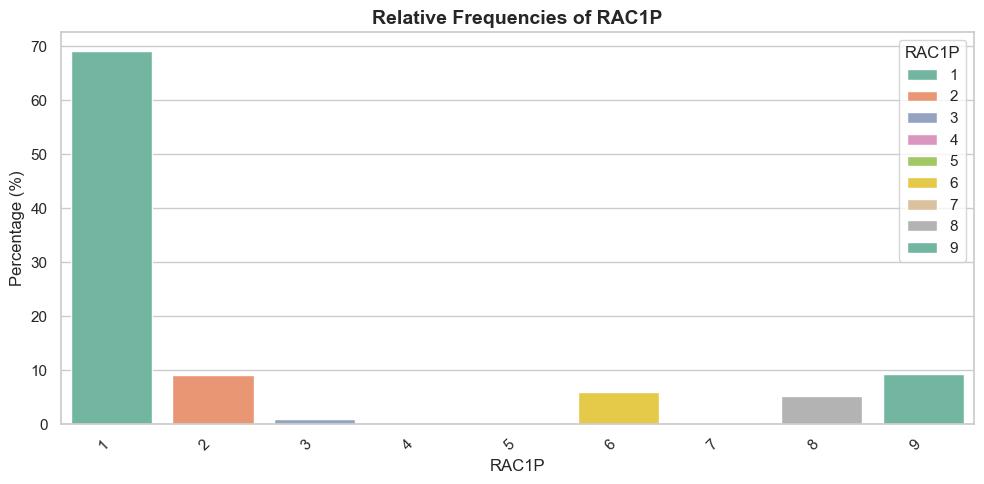

In [ ]:
sns.set_theme(style="whitegrid", palette="Set2")

limit_top_n = 30
columns_to_limit = ['OCCP', 'POBP'] 


for col in categorical_cols:
    plt.figure(figsize=(10, 5))

    # value counts normalized
    value_counts = insurance_data[col].value_counts(normalize=True) * 100
    
    if col in columns_to_limit:
        value_counts = value_counts.head(limit_top_n)

    plot_df = value_counts.reset_index()
    plot_df.columns = [col, 'percentage']

    sns.barplot(data=plot_df, x=col, y='percentage', hue=col, palette="Set2")
    
    plt.title(f'Relative Frequencies of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Creating thresholds and splitting datasets

### Income dataset

In [25]:

def preprocess_income_data(df, threshold):
    df_copy = df.copy()
    df_copy['binary_target'] = (df_copy['target'] >= threshold).astype(int)
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')
    y = df_copy['binary_target']
    return X, y


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough' 
)

threshold = 50000
X, y = preprocess_income_data(income_data, threshold)

# tempsplit: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# final split: validation (15%) and test (15%) from temp
X_val, X_test, y_val, y_test_income = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

preprocessor.fit(X_train)

X_train_income = preprocessor.transform(X_train)
X_val_income   = preprocessor.transform(X_val)
X_test_income  = preprocessor.transform(X_test)


In [26]:
y_train_income = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_income = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

### Health care dataset

In [32]:
def preprocess_healthcare_data(df):
    df_copy = df.copy()
    
    # Convert target values: 1 → 1 (with insurance), 2 → 0 (no insurance)
    df_copy['binary_target'] = (df_copy['target'] == 1).astype(int)

    # Separate features and target
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')
    y = df_copy['binary_target']
    
    return X, y

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough'
)

# Run preprocessing
X, y = preprocess_healthcare_data(insurance_data)

# Split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split: validation (15%) and test (15%)
X_val, X_test, y_val, y_test_health = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Fit and transform
preprocessor.fit(X_train)

X_train_health = preprocessor.transform(X_train)
X_val_health   = preprocessor.transform(X_val)
X_test_health  = preprocessor.transform(X_test)


In [33]:
y_train_health = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_health = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

In [34]:
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
numeric_cols_health =  ['AGEP', 'WKHP', 'PINCP']
all_feature_names_income = list(ohe_feature_names) + numeric_cols
all_feature_names_health = list(ohe_feature_names) + numeric_cols_health

### Linear baseline model for performance comparison ?

In [ ]:
#logreg = LogisticRegression(solver= 'saga', class_weight='balanced', max_iter=2500)
#logreg.fit(X_train_enc, y_train)
#y_pred_logreg = logreg.predict(X_test_enc)
#print(classification_report(y_test, y_pred_logreg))


## XGBoost Classifier

In [35]:
def tune_xgb_classifier(X_train, y_train, X_val, y_val, X_test, y_test, n_iter=20, random_state=42):
    param_dist = {
        'n_estimators': randint(100, 700),
        'max_depth': randint(3, 15),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'gamma': uniform(0, 5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1),
    }

    param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state))
    results = []

    for i, params in enumerate(param_list):
        print(f"\n Running trial {i+1}/{n_iter}...")
        print("Params:", params)
        start = time.time()

        model = XGBClassifier(eval_metric='logloss', n_jobs=-1, **params)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        val_f1 = f1_score(y_val, y_val_pred, average='macro')

        duration = time.time() - start
        print(f"Finished trial {i+1}/{n_iter} — Val F1 (macro): {val_f1:.4f} — Time: {duration:.1f}s")

        results.append((params, val_f1))

    best_params, best_score = max(results, key=lambda x: x[1])
    print("\nBest Hyperparameters:", best_params)
    print(f"Best Validation F1 (macro): {best_score:.4f}")

    # Train best model on full training data
    best_model = XGBClassifier(eval_metric='logloss', n_jobs=-1, **best_params)
    best_model.fit(X_train, y_train)

    y_test_pred = best_model.predict(X_test)
    print("\nFinal Test Set Performance:")
    print(classification_report(y_test, y_test_pred))

    return best_model, best_params, best_score


In [36]:
# For income prediction
xgmodel_income, params_income, score_income = tune_xgb_classifier(
    X_train_income, y_train_income, X_val_income, y_val_income, X_test_income, y_test_income
)

# For healthcare prediction
xgmodel_health, params_health, score_health = tune_xgb_classifier(
    X_train_health, y_train_health, X_val_health, y_val_health, X_test_health, y_test_health
)



 Running trial 1/20...
Params: {'colsample_bytree': np.float64(0.6872700594236812), 'gamma': np.float64(4.75357153204958), 'learning_rate': np.float64(0.22959818254342154), 'max_depth': 7, 'n_estimators': 221, 'reg_alpha': np.float64(0.15599452033620265), 'reg_lambda': np.float64(0.05808361216819946), 'subsample': np.float64(0.9330880728874675)}
Finished trial 1/20 — Val F1 (macro): 0.7964 — Time: 3.3s

 Running trial 2/20...
Params: {'colsample_bytree': np.float64(0.8005575058716043), 'gamma': np.float64(3.540362888980227), 'learning_rate': np.float64(0.016175348288740735), 'max_depth': 4, 'n_estimators': 443, 'reg_alpha': np.float64(0.8324426408004217), 'reg_lambda': np.float64(0.21233911067827616), 'subsample': np.float64(0.5909124836035503)}
Finished trial 2/20 — Val F1 (macro): 0.7816 — Time: 7.1s

 Running trial 3/20...
Params: {'colsample_bytree': np.float64(0.5917022549267169), 'gamma': np.float64(1.5212112147976886), 'learning_rate': np.float64(0.16742692948967136), 'max_dept

In [37]:
print(params_income)

{'colsample_bytree': np.float64(0.5911180438940311), 'gamma': np.float64(3.7768070515882624), 'learning_rate': np.float64(0.13754676234737342), 'max_depth': 8, 'n_estimators': 205, 'reg_alpha': np.float64(0.5677003278199915), 'reg_lambda': np.float64(0.03131329245555858), 'subsample': np.float64(0.9211423872974993)}


In [38]:
print(params_health)

{'colsample_bytree': np.float64(0.7248770666848828), 'gamma': np.float64(1.9757511800090721), 'learning_rate': np.float64(0.28799765973813823), 'max_depth': 10, 'n_estimators': 561, 'reg_alpha': np.float64(0.1959828624191452), 'reg_lambda': np.float64(0.045227288910538066), 'subsample': np.float64(0.6626651653816322)}


## TreeSHAP

### Income classifier

In [ ]:
# run ONLY IF you didn't run the previous code block

#params_income = {'colsample_bytree': np.float64(0.5917022549267169), 'gamma': np.float64(1.5212112147976886), 'learning_rate': np.float64(0.16742692948967136), 'max_depth': 14, 'n_estimators': 660, 'reg_alpha': np.float64(0.5247746602583891), 'reg_lambda': np.float64(0.3998609717152555), 'subsample': np.float64(0.5233328316068078)}

best_model_income = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **params_income
)
best_model_income.fit(X_train_income, y_train_income)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.5911180438940311), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=np.float64(3.7768070515882624), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.13754676234737342), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=205, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [40]:
income_explainer = shap.Explainer(best_model_income, feature_names = all_feature_names_income)
shap_values_income = income_explainer(X_test_income)

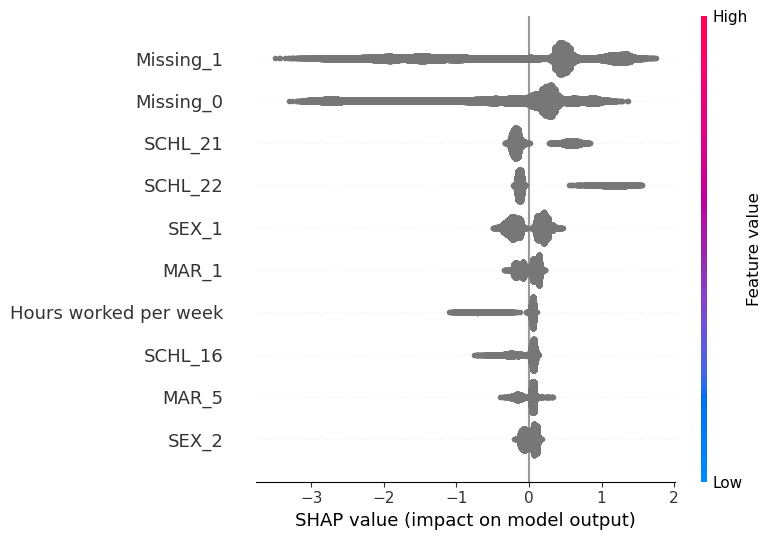

In [49]:
if len(shap_values_income.feature_names) < shap_values_income.values.shape[1]:
    missing_count = shap_values_income.values.shape[1] - len(shap_values_income.feature_names)
    shap_values_income.feature_names += [f"Missing_{i}" for i in range(missing_count)]


mean_abs_shap_income = np.abs(shap_values_income.values).mean(axis=0)

top_20_idx = np.argsort(mean_abs_shap_income)[-20:][::-1]

original_feature_names = shap_values_income.feature_names
top_20_features = np.array(original_feature_names)[top_20_idx]

custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1.0': 'Male',
    'DIS_1.0': 'With Disability',
    'SCHL_21.0': 'Bachelors Degree',
    'SCHL_22.0': 'Masters Degree',
    'NATIVITY_1.0': 'Native',
}


renamed_features = [
    custom_names.get(name, name)
    for name in original_feature_names
]
shap_values_income.feature_names = renamed_features


shap.summary_plot(shap_values_income, X_test_income, max_display=10)


In [50]:
print("SHAP values shape:", shap_values_income.values.shape)
print("Number of feature names:", len(shap_values_income.feature_names))

SHAP values shape: (75000, 318)
Number of feature names: 318


### Health care classifier

In [41]:
best_model_health = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **params_health
)
best_model_health.fit(X_train_health, y_train_health)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.7248770666848828), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=np.float64(1.9757511800090721), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.28799765973813823), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=561, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [42]:
health_explainer = shap.Explainer(best_model_health, feature_names = all_feature_names_health)
shap_values_health = health_explainer(X_test_health)

KeyboardInterrupt: 

In [ ]:
mean_abs_shap_health = np.abs(shap_values_health.values).mean(axis=0)
top_20_idx = np.argsort(mean_abs_shap_health)[-20:][::-1] 
top_20_features = np.array(shap_values_health.feature_names)[top_20_idx]
 
shap_values_health.feature_names = renamed_features
 
shap.summary_plot(shap_values_health, X_test_health, max_display=10)

## Simple FFNN

In [ ]:
def build_ffnn(input_dim, hidden_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))   # Input layer, preferred way
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

def train_ffnn_for_task(X_train, y_train, X_val, y_val, input_dim, n_iter=10, random_state=42):
    np.random.seed(random_state)

    param_dist = {
        'hidden_units': [32, 64, 128],
        'dropout_rate': [0.2, 0.3, 0.4],
        'learning_rate': [1e-2, 1e-3, 1e-4],
        'batch_size': [32, 64],
        'epochs': [10, 20]
    }

    def sample_params(param_dist):
        return {k: np.random.choice(v) for k, v in param_dist.items()}

    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(zip(np.unique(y_train), cw))

    results = []

    for i in range(n_iter):
        params = sample_params(param_dist)
        print(f"Trial {i+1}/{n_iter} with params: {params}")

        model = build_ffnn(
            input_dim=input_dim,
            hidden_units=params['hidden_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )

        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0,
            class_weight=class_weights
        )

        val_preds = model.predict(X_val).ravel()
        val_auc = roc_auc_score(y_val, val_preds)
        print(f"Val AUC: {val_auc:.4f}\n")

        results.append((params, val_auc))

    best_params, best_val_auc = max(results, key=lambda x: x[1])
    print(f" Best Params: {best_params}\n Best Val AUC: {best_val_auc:.4f}")

    # Train best model on full data (optionally)
    best_model = build_ffnn(
        input_dim=input_dim,
        hidden_units=best_params['hidden_units'],
        dropout_rate=best_params['dropout_rate'],
        learning_rate=best_params['learning_rate']
    )

    best_model.fit(
        X_train, y_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0,
        class_weight=class_weights
    )

    return best_model, best_params, best_val_auc


In [ ]:
input_dim_income = X_train_income.shape[1]
print("\n=== Training for Task: Income ===")
ffnn_model_income, params_income, auc_income = train_ffnn_for_task(
    X_train_income, y_train_income, X_val_income, y_val_income, input_dim_income
)

input_dim_health = X_train_health.shape[1]
print("\n=== Training for Task: Insurance ===")
ffnn_model_health, params_health, auc_health = train_ffnn_for_task(
    X_train_health, y_train_health, X_val_health, y_val_health, input_dim_health
)


In [ ]:
# test set evluation

print("\n=== Test Performance: Income ===")
test_preds_income = ffnn_model_income.predict(X_test_income).ravel()
test_auc_income = roc_auc_score(y_test_income, test_preds_income)
print(f"Test AUC: {test_auc_income:.4f}")
print(classification_report(y_test_income, test_preds_income > 0.5))

print("\n=== Test Performance: Insurance ===")
test_preds_health = ffnn_model_health.predict(X_test_health).ravel()
test_auc_health = roc_auc_score(y_test_health, test_preds_health)
print(f"Test AUC: {test_auc_health:.4f}")
print(classification_report(y_test_health, test_preds_health > 0.5))


## DeepSHAP

### Income

In [ ]:

# sample representative background set
background_size = 5000 #10000?

# stratified sample from training set
sss = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss.split(X_train_income, y_train_income))

background = X_train_income[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background

# get test data
X_test_array = X_test_income.toarray() if hasattr(X_test_income, "toarray") else X_test_income

# DeepSHAP

explainer = shap.DeepExplainer(ffnn_model_income, background)
deep_shap_values_income = explainer.shap_values(X_test_array)[0]  # [0] for binary output


In [ ]:
np.save('deep_shap_values_income.csv', deep_shap_values_income)

### Health insruance

In [ ]:

# sample representative background set
background_size = 5000 #10000?

# stratified sample from training set
sss = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss.split(X_train_health, y_train_health))

background = X_train_health[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background

# get test data
X_test_array = X_test_health.toarray() if hasattr(X_test_health, "toarray") else X_test_health

# DeepSHAP

explainer = shap.DeepExplainer(ffnn_model_health, background)
deep_shap_values_health = explainer.shap_values(X_test_array)[0]  # [0] for binary output


In [ ]:
np.save('deep_shap_values_health.csv', deep_shap_values_health)